In [122]:
!pip3 install pydicom
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pydicom as dcm
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import gc
import warnings
warnings.filterwarnings("ignore")

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
!unzip -o /content/drive/MyDrive/GreatLearning/stage_2_detailed_class_info.csv.zip
!unzip -o /content/drive/MyDrive/GreatLearning/stage_2_train_labels.csv.zip

Archive:  /content/drive/MyDrive/GreatLearning/stage_2_detailed_class_info.csv.zip
  inflating: stage_2_detailed_class_info.csv  
  inflating: __MACOSX/._stage_2_detailed_class_info.csv  
Archive:  /content/drive/MyDrive/GreatLearning/stage_2_train_labels.csv.zip
  inflating: stage_2_train_labels.csv  
  inflating: __MACOSX/._stage_2_train_labels.csv  


In [125]:
def read_csv(file_path):
  content = pd.read_csv(file_path)
  return content

project_path = '/content'
label_data = read_csv("/".join((project_path, 'stage_2_train_labels.csv')))
class_info = read_csv("/".join((project_path, 'stage_2_detailed_class_info.csv')))


In [126]:
label_data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [127]:
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [128]:
def merge_data_frames(left_df,right_df,merge_on):
  df = pd.merge(left = left_df, right = right_df, how = 'left', on = merge_on)
  df = df.drop_duplicates()
  df.info()

merge_data_frames(class_info,label_data,'patientId')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [129]:
class_info.dtypes

patientId    object
class        object
dtype: object

In [130]:
print("# of unique patient IDs: ", class_info['patientId'].nunique())

# of unique patient IDs:  26684


In [131]:
class_info['patientId'].value_counts().value_counts()

1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64

In [132]:
label_data.shape

(30227, 6)

In [133]:
label_data.dtypes

patientId     object
x            float64
y            float64
width        float64
height       float64
Target         int64
dtype: object

In [134]:
label_data.isnull().values.any()

True

In [135]:
label_data = label_data.fillna(0)
label_data.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


**Database table Preprocessing**

In [136]:
def check_for_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)   # finding total number of null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) #percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # putting the above two together
    return missing_data


In [137]:
check_for_missing_data(label_data)

,Total,Percent
Target,0,0.0
height,0,0.0
width,0,0.0
y,0,0.0
x,0,0.0
patientId,0,0.0


In [138]:
check_for_missing_data(class_info)

,Total,Percent
class,0,0.0
patientId,0,0.0


Observation : No missing value found in the class_info table. All the target values are filled therefore there is no empty value, cell with Nan or empty cell in label_data are having no phenumonia so let's replace those value with 

In [139]:
label_data.fillna(0, inplace=True)

In [140]:
label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [141]:
label_data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [142]:
label_data[label_data["Target"]==1].describe().T

,count,mean,std,min,25%,50%,75%,max
x,9555.0,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,366.839560,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,9555.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [143]:
np.unique(class_info["class"])  

array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
      dtype=object)

There are 3 classes - 


1.   Lung Opacity
2.   No Lung Opacity / Not Normal
3.   Normal



In [144]:
class_info[class_info["patientId"]=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal


In [145]:
label_data[label_data['patientId']=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0


No Lung Opacity / Not Normal has been classified as Target 0

In [146]:
class_info[class_info["patientId"]=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']


,patientId,class
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal


In [147]:
label_data[label_data['patientId']=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

,patientId,x,y,width,height,Target
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0


Normal has been classified as 0 as well

In [148]:
class_info[class_info["patientId"]=='00436515-870c-4b36-a041-de91049b9ab4']

,patientId,class
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [149]:
label_data[label_data['patientId']=='00436515-870c-4b36-a041-de91049b9ab4']

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Lung Opacity has been classified as 1 

In [150]:
!mkdir -p /content/sample_data/Stage2-data

os.chdir('/content/sample_data/Stage2-data/')

!pwd

!ls -lart '/content/sample_data/Stage2-data/'

/content/sample_data/Stage2-data
total 5128
-rw-rw-r-- 1 root root 1647396 Dec 11  2019 stage_2_detailed_class_info.csv
-rw-rw-r-- 1 root root 1490034 Dec 11  2019 stage_2_train_labels.csv
drwxr-xr-x 1 root root    4096 Dec  8 15:10 ..
drwxr-xr-x 2 root root 1867776 Dec  8 15:12 stage_2_train_images
drwxr-xr-x 2 root root  221184 Dec  8 15:25 stage_2_test_images
drwxr-xr-x 5 root root    4096 Dec  8 16:34 .
drwxr-xr-x 4 root root    4096 Dec  8 16:34 __MACOSX


In [151]:
from zipfile import ZipFile
import os


In [152]:
# Create a ZipFile Object and load sample.zip in it
def extract_zipFile(source_path,destination_path):
  try:
    with ZipFile(source_path, 'r') as zipObj:
      # Extract all the contents of zip file in current directory
      zipObj.extractall(destination_path)
  except Exception as e:
    print(str(e))


In [153]:
#extracting train images
print("Extracting train images...")
extract_zipFile('/content/drive/MyDrive/GreatLearning/stage_2_train_images.zip','/content/sample_data/Stage2-data/')

#extracting test images
print("Extracting test images..")
extract_zipFile('/content/drive/MyDrive/GreatLearning/stage_2_test_images.zip','/content/sample_data/Stage2-data/')

Extracting train images...
Extracting test images..


In [154]:
# Images Example
train_images_dir = "/".join(('/content/sample_data/Stage2-data/', "stage_2_train_images/"))
test_images_dir = "/".join(('/content/sample_data/Stage2-data/', "stage_2_test_images/"))
def parse_dicom_images(image_dir):
  images_list = []
  images = os.listdir(image_dir)
  for image in images:
    image_file = os.path.join(image_dir, image)
    if os.path.isfile(image_file):
      images_list.append(image_file)
  return images_list

In [155]:
train_images = parse_dicom_images(train_images_dir)
test_images = parse_dicom_images(test_images_dir)
print('5 Training images', train_images[:5])
print('5 Test images', test_images[:5])

5 Training images ['/content/sample_data/Stage2-data//stage_2_train_images/55aecdc5-76dd-46c0-85e9-58e47199894f.dcm', '/content/sample_data/Stage2-data//stage_2_train_images/a09b69db-fcf3-4ab3-8b7f-a430c8740853.dcm', '/content/sample_data/Stage2-data//stage_2_train_images/5b888035-c53f-4f6b-b00e-1550214d108e.dcm', '/content/sample_data/Stage2-data//stage_2_train_images/bde5d050-10b4-4a55-9c5a-b509013483f6.dcm', '/content/sample_data/Stage2-data//stage_2_train_images/6cbc978a-50ee-46b4-b0b7-5201b50d19b5.dcm']
5 Test images ['/content/sample_data/Stage2-data//stage_2_test_images/0320cae5-82c5-460e-96f8-754354697b8e.dcm', '/content/sample_data/Stage2-data//stage_2_test_images/043711b3-ff14-463a-b38a-6f8e2d0b1a9a.dcm', '/content/sample_data/Stage2-data//stage_2_test_images/0377791b-ae5b-4abb-b6ae-ac8582ac6f33.dcm', '/content/sample_data/Stage2-data//stage_2_test_images/c1d1a7c9-94b3-44e3-9353-3ec35fce7d70.dcm', '/content/sample_data/Stage2-data//stage_2_test_images/110dfcba-05da-425e-a691-

In [156]:
column_list = ["Patient ID", "Patient Sex", "Patient's Age", "View Position", "Image Size"]
file_meta_Data = pd.DataFrame(columns=column_list)

def add_images_to_df(df,images_list,count_limit=100):
    data = []
    count = 0
    for image_path in images_list:
      data_row_img_data = dcm.read_file(image_path)
      values = []
      count = count + 1
      values.append(data_row_img_data.PatientID)
      values.append(data_row_img_data.PatientSex)
      values.append(data_row_img_data.PatientAge)
      values.append(data_row_img_data.ViewPosition)
      values.append(f"{data_row_img_data.Rows}x{data_row_img_data.Columns}")
      zipped_val = dict(zip(column_list, values))
      df = df.append(zipped_val, True)
    print(df)
    return df

In [157]:
file_meta_Data = add_images_to_df(file_meta_Data, train_images,1000)

                                 Patient ID  ... Image Size
0      55aecdc5-76dd-46c0-85e9-58e47199894f  ...  1024x1024
1      a09b69db-fcf3-4ab3-8b7f-a430c8740853  ...  1024x1024
2      5b888035-c53f-4f6b-b00e-1550214d108e  ...  1024x1024
3      bde5d050-10b4-4a55-9c5a-b509013483f6  ...  1024x1024
4      6cbc978a-50ee-46b4-b0b7-5201b50d19b5  ...  1024x1024
...                                     ...  ...        ...
26679  091781dd-be2b-4517-9264-ade2f0c85487  ...  1024x1024
26680  a613b9d5-b499-48e2-b23f-f78b657019ef  ...  1024x1024
26681  99411044-20f4-43a7-a9db-699ddbf7049b  ...  1024x1024
26682  39a5e461-791e-45f0-a4a9-2f4d06c8eca8  ...  1024x1024
26683  44875737-1f1d-4856-8832-54d442080439  ...  1024x1024

[26684 rows x 5 columns]


In [158]:
file_meta_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Patient ID     26684 non-null  object
 1   Patient Sex    26684 non-null  object
 2   Patient's Age  26684 non-null  object
 3   View Position  26684 non-null  object
 4   Image Size     26684 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


In [159]:
dicom_file_path = os.path.join(train_images_dir + "/" + "05eebe4c-bca2-40d4-bb20-54fc60e2bcea.dcm")
file = dcm.read_file(dicom_file_path)
file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.15214.1517874384.336739
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.15214.1517874384.336739
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

Data Visualisation

In [160]:
gc.collect()

162

In [161]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("","/content/sample_data/Stage2-data/stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target:'.format(
                data_row['patientId'],modality, age, sex, data_row['Target']))
        rows = label_data[label_data['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="red",alpha = 0.1))   
    plt.show()


<class 'pandas.core.frame.DataFrame'>
                               patientId      x      y  width  height  Target
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1


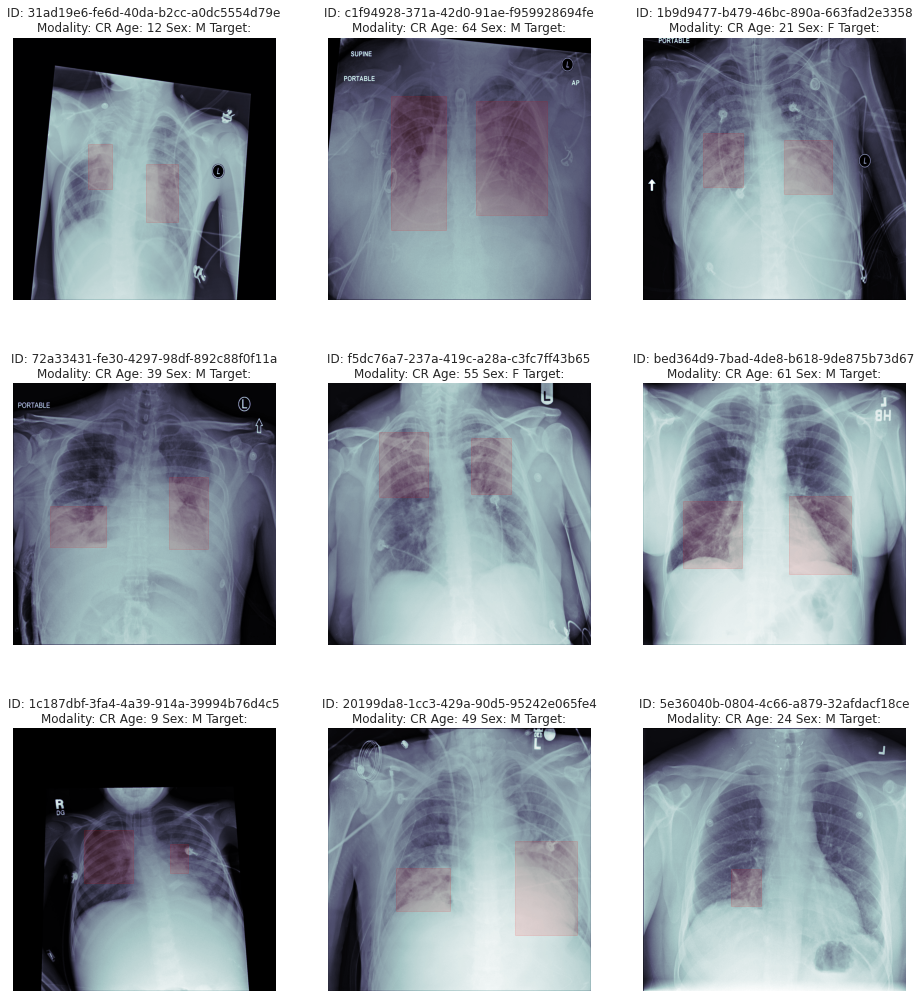

In [162]:
target = label_data[label_data['Target']==1]
print(type(target))
print(target.head())
#generating 9 row
show_dicom_images_with_boxes(label_data[label_data['Target']==1].sample(9))

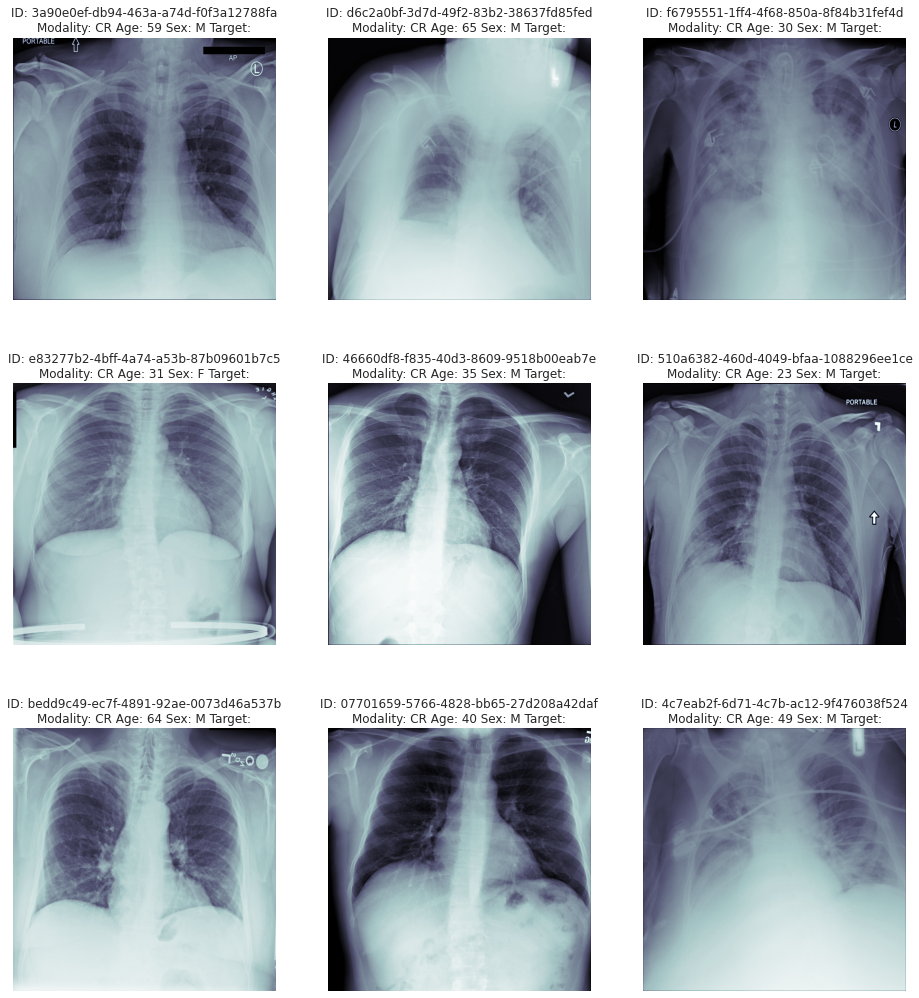

In [163]:
show_dicom_images_with_boxes(label_data[label_data['Target']==0].sample(9))

In [164]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("/content/sample_data/Stage2-data/stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: \nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

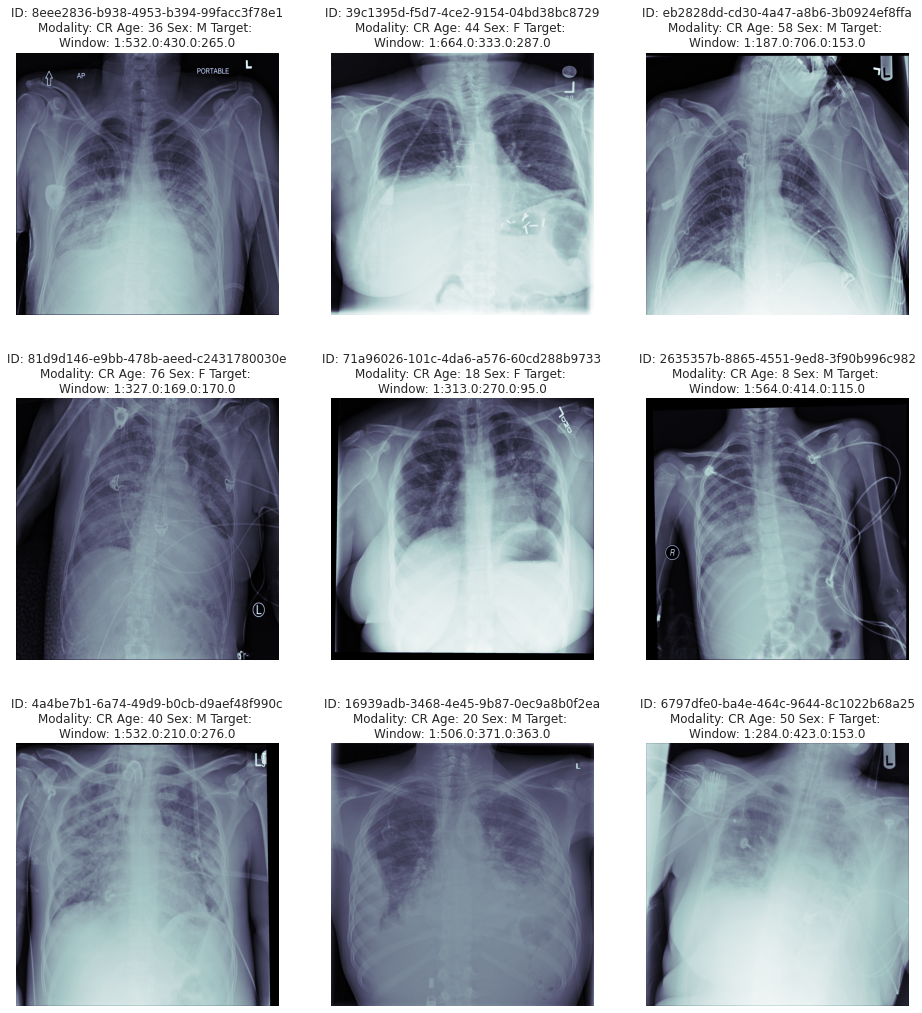

In [165]:
show_dicom_images(label_data[label_data['Target']==1].sample(9))

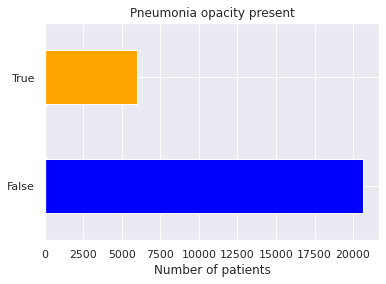

In [166]:
boxes_per_patient = label_data.groupby('patientId')['Target'].sum()

ax = (boxes_per_patient > 0).value_counts().plot.barh(color=['blue','orange'])
_ = ax.set_title('Pneumonia opacity present')
_ = ax.set_xlabel('Number of patients')
_ = ax.xaxis.set_tick_params(rotation=0)

In [167]:
import seaborn as sns
sns.set(color_codes=True)
print(label_data.keys())

Index(['patientId', 'x', 'y', 'width', 'height', 'Target'], dtype='object')


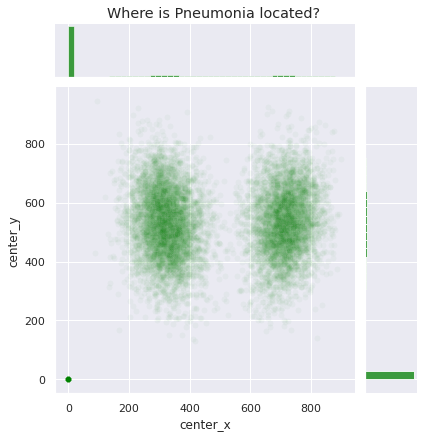

In [168]:
centers = (label_data.dropna(subset=['x'])
           .assign(center_x=label_data.x + label_data.width / 2, 
                   center_y=label_data.y + label_data.height / 2))
ax = sns.jointplot("center_x", "center_y", data=centers, height=6, alpha=0.03, color="green")
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

In [169]:
label_data['aspect_ratio'] = (label_data['width'] / 
                                        label_data['height'])
label_data['area'] = label_data['width'] * label_data['height']

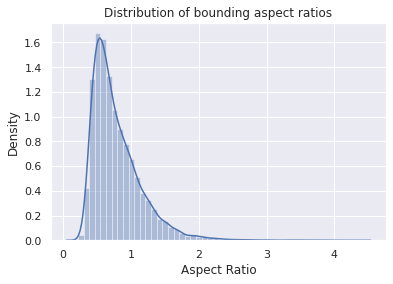

In [170]:
ax = sns.distplot(label_data['aspect_ratio'].dropna(), norm_hist=True)
_ = ax.set_title("Distribution of bounding aspect ratios")
_ = ax.set_xlabel("Aspect Ratio")

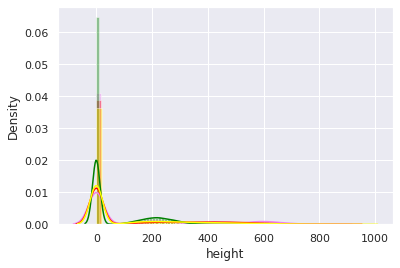

In [171]:
sns.distplot(label_data['x'],kde=True,bins=50, color="violet")
sns.distplot(label_data['y'],kde=True,bins=50, color="red")
sns.distplot(label_data['width'],kde=True,bins=50, color="green")
sns.distplot(label_data['height'],kde=True,bins=50, color="yellow")
